mu = 2 start
26
mu = 15 start
8
mu = 50 start
7
mu = 100 start
6
mu = 500 start
5
mu = 1000 start
5


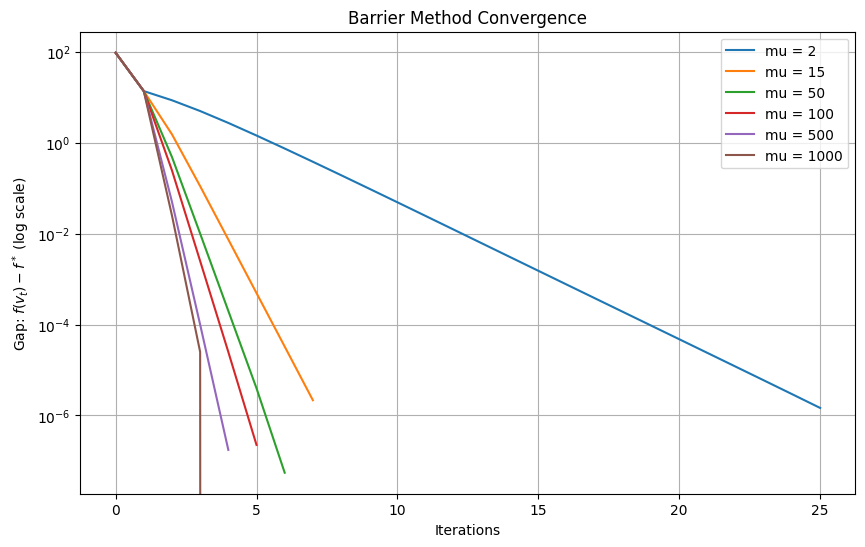

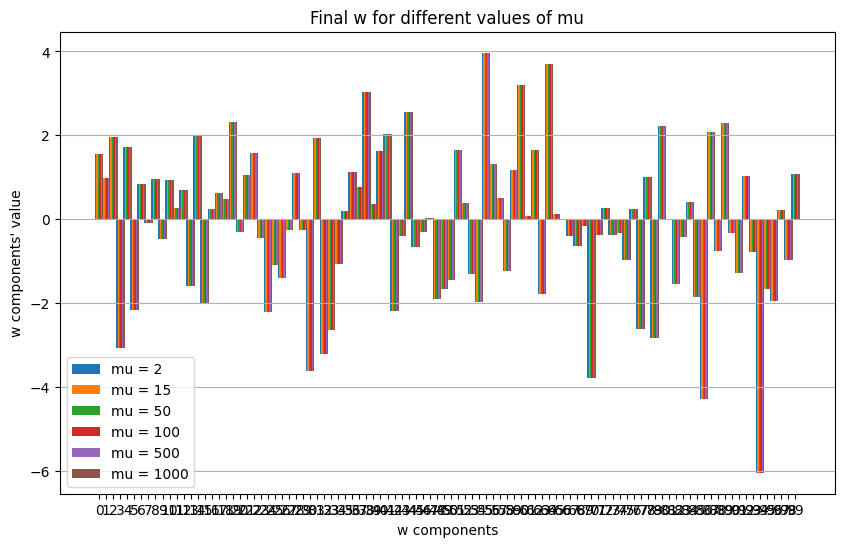

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def centering_step(Q, p, A, b, t, v0, eps):
    """
    Implements Newton's method for solving the centering step.
    
    Parameters:
        Q (ndarray): Positive semidefinite matrix for the quadratic term.
        p (ndarray): Coefficient vector for the linear term.
        A (ndarray): Equality constraint matrix.
        b (ndarray): Equality constraint vector.
        t (float): Barrier parameter.
        v0 (ndarray): Initial variable.
        eps (float): Target precision.
    
    Returns:
        v_seq (list): Sequence of variable iterates achieving epsilon-precision.
    """
    def objective(v):
        return (1/2) * v.T @ Q @ v + p.T @ v - (1/t) * np.sum(np.log(b - A @ v))
    
    def gradient(v):
        g = Q @ v + p + (1/t) * A.T @ (1 / (b - A @ v))
        return g
    
    def hessian(v):
        D = np.diag(1 / (b - A @ v)**2)
        H = Q + (1/t) * A.T @ D @ A
        return H

    def backtracking_line_search(v, grad, direction, alpha=0.4, beta=0.9):
        step = 1.0
        while True:
            new_v = v + step * direction
            if np.all(b - A @ new_v > 0) and \
               objective(new_v) <= objective(v) + alpha * step * grad.T @ direction:
                break
            step *= beta
        return step

    v = v0
    v_seq = [v0]
    mini_count = 0
    while True:
        mini_count += 1
        grad = gradient(v)
        hess = hessian(v)
        
        # FInd Newton direction
        direction = np.linalg.solve(hess, -grad)
        
        # Check convergence
        if np.linalg.norm(grad, ord=2) < eps:
            break
        
        # Backtracking line search
        step_size = backtracking_line_search(v, grad, direction)
        
        # Update variable
        v = v + step_size * direction
        v_seq.append(v)


    return v_seq

def barr_method(Q, p, A, b, v0, eps, t0=1, mu=10):
    """
    Implements the barrier method to solve a quadratic program using the centering step.
    
    Parameters:
        Q (ndarray): Positive semidefinite matrix for the quadratic term.
        p (ndarray): Coefficient vector for the linear term.
        A (ndarray): Inequality constraint matrix.
        b (ndarray): Inequality constraint vector.
        v0 (ndarray): Initial feasible point.
        eps (float): Target precision.
        t0 (float): Initial value of barrier parameter t (default: 1).
        mu (float): Scaling factor for t (default: 10).
    
    Returns:
        v_seq (list): Sequence of variable iterates achieving epsilon-precision.
    """
    
    def duality_gap(v, t):
        return A.shape[0] / t  # Number of constraints divided by t

    # Initialize parameters
    t = t0
    v = v0
    v_seq = [v0]  # Store sequence of iterates

    count = 0
    
    while True:
        count += 1
        # Perform centering step
        v = centering_step(Q, p, A, b, t, v, eps)[-1]
        v_seq.append(v)
        
        # Check stopping criterion
        if duality_gap(v, t) < eps:
            break
        
        # Update t
        t *= mu
    
    return v_seq


def generate_data(n, d, lam):
    """
    Generate random data matrices X and y for the quadratic program.
    """
    X = np.random.randn(n, d)
    y = np.random.randn(n)
    Q = (1/2) * np.eye(n)  # Q = 1/2 * Identity
    p = -y
    A = np.vstack([X.T, -X.T])  # Stack +X^T and -X^T
    b = lam * np.ones(2 * d)  # lambda * 1_{2d}
    return Q, p, A, b, X, y

n = 100
d = 50
lambda_ = 10

Q, p, A, b, X, y = generate_data(n, d, lambda_)

# Feasible starting point        
v0 = np.zeros(n)

# Different parameters
mu_values = [2, 15, 50, 100, 500, 1000]
results = {}

for mu in mu_values:
    print(f"mu = {mu} start")
    v_seq_ = barr_method(Q, p, A, b, v0, eps=1e-5, mu=mu, t0=1)
    results[mu] = v_seq_
    print(len(v_seq_))
    

# Visualisation of f(v) - f*


def objective_function(v):
    return 0.5 * v.T @ Q @ v + p.T @ v

# Use the best final value found for f*
f_star = min(objective_function(sequence[-1]) for sequence in results.values())

# Plotting
plt.figure(figsize=(10, 6))
for mu, sequence in results.items():
    f_values = [objective_function(v) for v in sequence]
    gap = [f - f_star for f in f_values]
    plt.semilogy(gap, label=f"mu = {mu}")

plt.xlabel("Iterations")
plt.ylabel("Gap: $f(v_t) - f^*$ (log scale)")
plt.title("Barrier Method Convergence")
plt.legend()
plt.grid(True)
plt.show()


final_solutions = {}

for mu, sequence in results.items():
    final_solutions[mu] = sequence[-1] 


plt.figure(figsize=(10, 6))
bar_width = 0.2  

indices = np.arange(len(final_solutions[2]))  
for i, (mu, w_star) in enumerate(final_solutions.items()):
    plt.bar(indices + i * bar_width, w_star, bar_width, label=f"mu = {mu}")

plt.xlabel("w components")
plt.ylabel("w components' value")
plt.title("Final w for different values of mu")
plt.xticks(indices + bar_width * (len(final_solutions) - 1) / 2, indices)  # Center ticks
plt.legend()
plt.grid(axis="y")
plt.show()